In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

# The Data

The dataset contains a company's list of customers, along with their demographic information, and their purchasing habits. This dataset was obtained from Kaggle.

## Attributes

### People
- ID: Customer's unique identifier
- Year_Birth: Customer's birth year
- Education: Customer's education level
- Marital_Status: Customer's marital status
- Income: Customer's yearly household income
- Kidhome: Number of children in customer's household
- Teenhome: Number of teenagers in customer's household
- Dt_Customer: Date of customer's enrollment with the company
- Recency: Number of days since customer's last purchase
- Complain: 1 if customer complained in the last 2 years, 0 otherwise

### Products
- MntWines: Amount spent on wine in last 2 years
- MntFruits: Amount spent on fruits in last 2 years
- MntMeatProducts: Amount spent on meat in last 2 years
- MntFishProducts: Amount spent on fish in last 2 years
- MntSweetProducts: Amount spent on sweets in last 2 years
- MntGoldProds: Amount spent on gold in last 2 years

### Promotion
- NumDealsPurchases: Number of purchases made with a discount
- AcceptedCmp1: 1 if customer accepted the offer in the 1st campaign, 0 otherwise
- AcceptedCmp2: 1 if customer accepted the offer in the 2nd campaign, 0 otherwise
- AcceptedCmp3: 1 if customer accepted the offer in the 3rd campaign, 0 otherwise
- AcceptedCmp4: 1 if customer accepted the offer in the 4th campaign, 0 otherwise
- AcceptedCmp5: 1 if customer accepted the offer in the 5th campaign, 0 otherwise
- Response: 1 if customer accepted the offer in the last campaign, 0 otherwise

### Place
- NumWebPurchases: Number of purchases made through the company’s web site
- NumCatalogPurchases: Number of purchases made using a catalogue
- NumStorePurchases: Number of purchases made directly in stores
- NumWebVisitsMonth: Number of visits to company’s web site in the last month

In [2]:
# load the dataset
data = pd.read_csv("data/marketing_campaign.csv", sep="\t")
data

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,10870,1967,Graduation,Married,61223.0,0,1,13-06-2013,46,709,...,5,0,0,0,0,0,0,3,11,0
2236,4001,1946,PhD,Together,64014.0,2,1,10-06-2014,56,406,...,7,0,0,0,1,0,0,3,11,0
2237,7270,1981,Graduation,Divorced,56981.0,0,0,25-01-2014,91,908,...,6,0,1,0,0,0,0,3,11,0
2238,8235,1956,Master,Together,69245.0,0,1,24-01-2014,8,428,...,3,0,0,0,0,0,0,3,11,0


# Data Cleaning 

In [3]:
# drop the rows with missing values
data = data.dropna()

In [4]:
# compute the number of days each customer has been enrolled at the store, relative to the most recent customer enrolled

# get the most recent enrollment date
enrollment_dates = pd.to_datetime(data['Dt_Customer'])
most_recent_date = enrollment_dates.max()

# get each customer's number of days enrolled relative to the most recent enrollment date
days_enrolled_list = []
for date in enrollment_dates:
    days_enrolled = (most_recent_date - date).days
    days_enrolled_list.append(days_enrolled)

data['Days_Enrolled'] = days_enrolled_list

In [5]:
# compute each customer's age
data['Age'] = 2021 - data['Year_Birth']

In [6]:
# compute each customer's total spending
data['Total_Spent'] = data["MntWines"] + data["MntFruits"] + data["MntMeatProducts"] + data["MntFishProducts"] + data["MntSweetProducts"] + data["MntGoldProds"]

In [7]:
# calculate the total number of purchases made by each customer
data['Total_Purchases'] = data['NumWebPurchases'] + data['NumCatalogPurchases'] + data['NumStorePurchases']

In [8]:
# get the marital status responses
print("Marital_Status Responses:\n", data["Marital_Status"].value_counts())

Marital_Status Responses:
 Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
YOLO          2
Absurd        2
Name: Marital_Status, dtype: int64


In [9]:
# change Marital_Status into a binary attribute (0 for single, 1 if in a relationship)

for i, marital_status in data['Marital_Status'].items():
    if marital_status in ('Married', 'Together'):
        data.loc[i, 'Marital_Status'] = 1
    else:
        data.loc[i, 'Marital_Status'] = 0

In [10]:
# get the education level responses
print("Education Responses:\n", data["Education"].value_counts())

Education Responses:
 Graduation    1116
PhD            481
Master         365
2n Cycle       200
Basic           54
Name: Education, dtype: int64


In [11]:
# change Education into either 'Undergraduate', 'Graduate', or "Postgraduate"

for i, education in data["Education"].items():
    if education in ('2n Cycle', 'Basic'):
        data.loc[i, 'Education'] = 'Undergraduate'
    elif education == 'Graduation':
        data.loc[i, 'Education'] = 'Graduate'
    else: 
        data.loc[i, 'Education'] = 'Postgraduate'

In [12]:
for i, kid_home in data['Kidhome'].items():
    if kid_home > 1:
        data.loc[i, 'Kidhome'] = 1
        
for i, teen_home in data['Teenhome'].items():
    if teen_home > 1:
        data.loc[i, 'Teenhome'] = 1

In [13]:
# drop unneeded columns
data.drop(["Dt_Customer", "Z_CostContact", "Z_Revenue", "Year_Birth", "ID"], axis=1, inplace=True)

In [14]:
data.describe()

,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,...,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Days_Enrolled,Age,Total_Spent,Total_Purchases
count,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,...,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000
mean,52247.251354,0.421029,0.482401,49.012635,305.091606,26.356047,166.995939,37.637635,27.028881,43.965253,...,0.074007,0.073105,0.064079,0.013538,0.009477,0.150271,512.006318,52.179603,607.075361,12.557310
std,25173.076661,0.493836,0.499803,28.948352,337.327920,39.793917,224.283273,54.752082,41.072046,51.815414,...,0.261842,0.260367,0.244950,0.115588,0.096907,0.357417,232.469034,11.985554,602.900476,7.204611
min,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000,5.000000,0.000000
25%,35303.000000,0.000000,0.000000,24.000000,24.000000,2.000000,16.000000,3.000000,1.000000,9.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,340.000000,44.000000,69.000000,6.000000
50%,51381.500000,0.000000,0.000000,49.000000,174.500000,8.000000,68.000000,12.000000,8.000000,24.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,513.000000,51.000000,396.500000,12.000000
75%,68522.000000,1.000000,1.000000,74.000000,505.000000,33.000000,232.250000,50.000000,33.000000,56.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,686.000000,62.000000,1048.000000,18.000000
max,666666.000000,1.000000,1.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,262.000000,321.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1063.000000,128.000000,2525.000000,32.000000


Based on the above data distributions, there is significant variance between the mean income and max income (24.4 standard deviations). There is also significant variance between the mean age and the max age (6.3 standard deviations). Therefore, there are likely outliers in these categories.

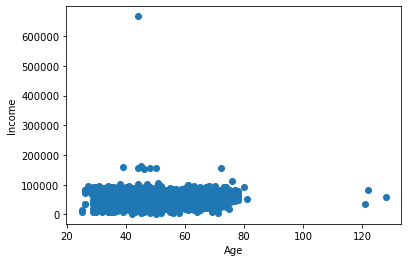

In [15]:
# plot age and income
plt.plot(data['Age'], data['Income'], 'o')
plt.xlabel("Age")
plt.ylabel("Income")
plt.show()

Based on the above scatter plot, nearly all of the ages are below 90, and nearly all income is below 200000.

In [16]:
# remove the outliers
data = data[(data["Age"]<90)]
data = data[(data["Income"]<200000)]

## Data after cleaning:

In [17]:
data

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Days_Enrolled,Age,Total_Spent,Total_Purchases
0,Graduate,0,58138.0,0,0,58,635,88,546,172,...,0,0,0,0,0,1,971,64,1617,22
1,Graduate,0,46344.0,1,1,38,11,1,6,2,...,0,0,0,0,0,0,125,67,27,4
2,Graduate,1,71613.0,0,0,26,426,49,127,111,...,0,0,0,0,0,0,472,56,776,20
3,Graduate,1,26646.0,1,0,26,11,4,20,10,...,0,0,0,0,0,0,65,37,53,6
4,Postgraduate,1,58293.0,1,0,94,173,43,118,46,...,0,0,0,0,0,0,321,40,422,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,Graduate,1,61223.0,0,1,46,709,43,182,42,...,0,0,0,0,0,0,541,54,1341,16
2236,Postgraduate,1,64014.0,1,1,56,406,0,30,0,...,0,0,1,0,0,0,61,75,444,15
2237,Graduate,0,56981.0,0,0,91,908,48,217,32,...,1,0,0,0,0,0,315,40,1241,18
2238,Postgraduate,1,69245.0,0,1,8,428,30,214,80,...,0,0,0,0,0,0,316,65,843,21


# Data Preprocessing

In [18]:
data_numerical = data.copy()

In [19]:
# convert Education into an ordered numerical attribute
data_numerical['Education'] = data['Education'].replace({'Undergraduate': 0, 'Graduate': 1, 'Postgraduate': 3})

In [20]:
data_numerical = data_numerical.drop(['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4','AcceptedCmp5', 'Complain', 'Response'], axis=1)

In [21]:
# scale the data
scaler = StandardScaler()
scaler.fit(data_numerical)
data_std = pd.DataFrame(scaler.transform(data_numerical),columns=data_numerical.columns)

## Data after preprocessing:

In [22]:
data_std

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Days_Enrolled,Age,Total_Spent,Total_Purchases
0,-0.588725,-1.349603,0.287105,-0.852512,-0.966212,0.310353,0.977660,1.552041,1.690293,2.453472,...,0.852576,0.351030,1.426865,2.503607,-0.555814,0.692181,1.973583,1.018352,1.676245,1.309461
1,-0.588725,-1.349603,-0.260882,1.173005,1.034969,-0.380813,-0.872618,-0.637461,-0.718230,-0.651004,...,-0.733642,-0.168701,-1.126420,-0.571340,-1.171160,-0.132545,-1.665144,1.274785,-0.963297,-1.189221
2,-0.588725,0.740959,0.913196,-0.852512,-0.966212,-0.795514,0.357935,0.570540,-0.178542,1.339513,...,-0.037254,-0.688432,1.426865,-0.229679,1.290224,-0.544908,-0.172664,0.334530,0.280110,1.031830
3,-0.588725,0.740959,-1.176114,1.173005,-0.966212,-0.795514,-0.872618,-0.561961,-0.655787,-0.504911,...,-0.752987,-0.168701,-0.761665,-0.913000,-0.555814,0.279818,-1.923210,-1.289547,-0.920135,-0.911590
4,1.222484,0.740959,0.294307,1.173005,-0.966212,1.554453,-0.392257,0.419540,-0.218684,0.152508,...,-0.559545,1.390492,0.332600,0.111982,0.059532,-0.132545,-0.822130,-1.033114,-0.307562,0.198936
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2207,-0.588725,0.740959,0.430444,-0.852512,1.034969,-0.104347,1.197084,0.419540,0.066770,0.079461,...,3.928291,-0.168701,1.791619,0.111982,-0.555814,-0.132545,0.124112,0.163575,1.218061,0.476567
2208,1.222484,0.740959,0.560123,1.173005,1.034969,0.241237,0.298631,-0.662628,-0.611184,-0.687527,...,-0.694954,2.429954,1.426865,-0.229679,-0.248141,0.692181,-1.940414,1.958607,-0.271040,0.337751
2209,-0.588725,-1.349603,0.233347,-0.852512,-0.966212,1.450778,1.787156,0.545373,0.222878,-0.103155,...,-0.385448,-0.688432,-0.761665,0.111982,2.213242,0.279818,-0.847936,-1.033114,1.052052,0.754198
2210,1.222484,0.740959,0.803172,-0.852512,1.034969,-1.417564,0.363866,0.092373,0.209498,0.773403,...,0.330284,-0.168701,0.697355,0.795303,1.290224,-0.957271,-0.843635,1.103830,0.391336,1.170645


# Principal Component Analysis

In [23]:
# perform PCA on the data and get the explained variances for the top 10 components
pca = PCA(n_components=10)
pca.fit(data_std)
exp_var = pca.explained_variance_ratio_

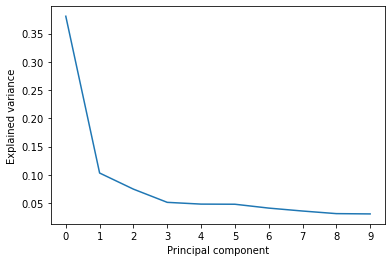

In [24]:
# create a Scree-plot for the top 10 components
plt.plot(np.arange(10), exp_var)
plt.xticks(np.arange(10))
plt.xlabel("Principal component")
plt.ylabel("Explained variance")
plt.show()

Using the elbow method on the above Scree-plot, I will choose the top 3 components to reduce the data into 3 dimensions.

In [25]:
# project the data into 3 dimensions
pca.n_components = 3
pca.fit(data_std)
data_reduced = pd.DataFrame(pca.transform(data_std), columns=["dim1", "dim2", "dim3"])

## Data after projecting into 3 dimensions:

In [26]:
data_reduced

,dim1,dim2,dim3
0,4.432758,0.036449,2.352633
1,-2.844515,-0.279105,-1.728706
2,2.131482,-0.306930,-0.025112
3,-2.995978,-1.631028,0.003181
4,-0.306692,-0.073908,0.267598
...,...,...,...
2207,2.958005,0.996153,1.203857
2208,-0.837510,3.196180,-1.676390
2209,1.752697,-0.921073,0.044213
2210,2.364661,1.085688,-1.977368


# Clustering

In [27]:
# perform K-means clustering with k=2 through k=10, and get the sum of within-cluster variance for each k
num_clusters = range(2, 11)
cluster_variance = []

for k in num_clusters:
    kmeans = KMeans(n_clusters=k).fit(data_reduced)
    cluster_variance.append(kmeans.inertia_)

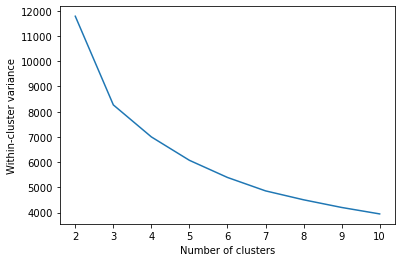

In [28]:
# plot num_clusters and cluster_variance
plt.plot(num_clusters, cluster_variance)
plt.xlabel("Number of clusters")
plt.ylabel("Within-cluster variance")
plt.show()

Using the elbow method on the above graph, I will choose to make 4 clusters.

In [29]:
# perform K-means clustering with k=4
kmeans = KMeans(n_clusters=4).fit(data_reduced)
kmeans_clusters = kmeans.labels_

In [30]:
# get the silhouette score for K-means clustering with k=4
kmeans_score = silhouette_score(data_reduced, kmeans_clusters)
print("Silhouette score for K-means clustering: " + str(kmeans_score))

Silhouette score for K-means clustering: 0.3325509311675692


In [31]:
# run agglomerative clustering using Ward linkage to create 4 clusters
ward_linkage = AgglomerativeClustering(n_clusters=4, linkage='ward').fit(data_reduced)
ward_clusters = ward_linkage.labels_

In [2]:
# compute silhouette score
ward_score = silhouette_score(data_reduced, ward_clusters)
print("Silhouette score for Ward linkage: " + str(ward_score))

Silhouette score for Ward linkage: 0.41679412310273684


In [33]:
complete_linkage = AgglomerativeClustering(n_clusters=4, linkage='complete').fit(data_reduced)
complete_clusters = complete_linkage.labels_

In [3]:
complete_score = silhouette_score(data_reduced, complete_clusters)
print("Silhouette score for complete linkage: " + str(complete_score))

Silhouette score for complete linkage: 0.3361602538780253


In [35]:
average_linkage = AgglomerativeClustering(n_clusters=4, linkage='average').fit(data_reduced)
average_clusters = average_linkage.labels_

In [5]:
average_score = silhouette_score(data_reduced, average_clusters)
print("Silhouette score for average linkage: " + str(average_score))

Silhouette score for average linkage: 0.33050981223847875


In [37]:
single_linkage = AgglomerativeClustering(n_clusters=4, linkage='single').fit(data_reduced)
single_clusters = single_linkage.labels_

In [6]:
single_score = silhouette_score(data_reduced, single_clusters)
print("Silhouette score for single linkage: " + str(single_score))

Silhouette score for single linkage: 0.17864276483130326


I will use the clusters produced by the Ward linkage method, since this produced the highest Silhoette score.

In [39]:
# add the clusters to the original and reduced data
data["Cluster"] = ward_clusters
data_reduced["Cluster"] = ward_clusters

In [40]:
data.to_csv('data.csv', index=False)

# Cluster Analysis

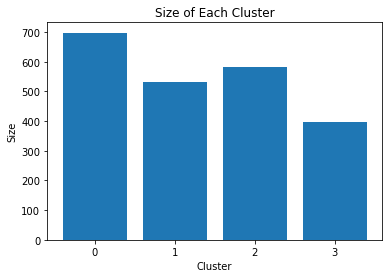

In [4]:
cluster_sizes = data["Cluster"].value_counts()
cluster_sizes.sort_index(inplace=True)
X_axis = np.arange(4)
  
plt.bar(X_axis, cluster_sizes.values)
  
plt.xticks(X_axis)
plt.xlabel("Cluster")
plt.ylabel("Size")
plt.title("Size of Each Cluster")
plt.show()

- All of the clusters have similar sizing, except cluster 3 is smaller than the others.

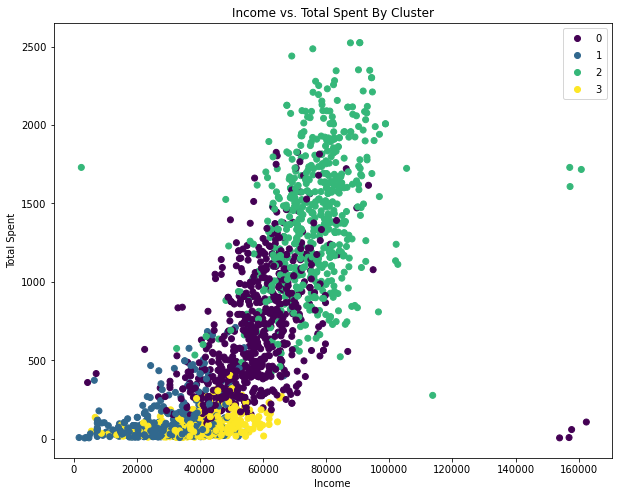

In [6]:
# plot income vs. total spent for each cluster
plt.figure(figsize=(10,8))
scatter = plt.scatter(data['Income'], data['Total_Spent'], c=data['Cluster'], marker='o')
plt.title("Income vs. Total Spent By Cluster")
plt.xlabel("Income")
plt.ylabel("Total Spent")
plt.legend(*scatter.legend_elements())
plt.show()

- There is a strong correlation between income and total spending. 
- Cluster 1 makes the least income and spends the least.
- Cluster 3 makes middle income and spends low.
- Cluster 0 makes middle income and spends high.
- Cluster 2 makes the most income and spends the most.

## Demographics

In [7]:
# calculate the total number of purchases made by each customer
# data['Total_Purchases'] = data['NumWebPurchases'] + data['NumCatalogPurchases'] + data['NumStorePurchases']

In [8]:
# get the data from each cluster
clust_0 = data[data['Cluster'] == 0]
clust_1 = data[data['Cluster'] == 1]
clust_2 = data[data['Cluster'] == 2]
clust_3 = data[data['Cluster'] == 3]

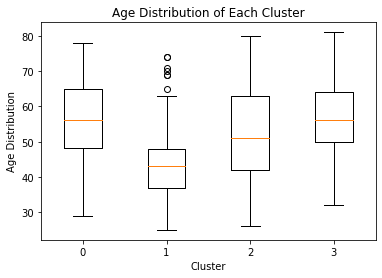

In [9]:
# draw a boxplot of each cluster's age distribution
fig1, ax1 = plt.subplots()
ax1.set_title('Age Distribution of Each Cluster')
ax1.boxplot([clust_0['Age'], clust_1['Age'], clust_2['Age'], clust_3['Age']], labels=range(4))
plt.xlabel("Cluster")
plt.ylabel("Age Distribution")
plt.show()

From the above boxplot:
- Cluster 1 is relatively younger.
- Clusters 0 and 3 are relatively older.
- Cluster 2 spans across all age groups.

In [10]:
# get ratios of each cluster that have kids and teens

clust_0_kid = len(clust_0[clust_0['Kidhome']>0]) / cluster_sizes[0]
clust_0_teen = len(clust_0[clust_0['Teenhome']>0]) / cluster_sizes[0]

clust_1_kid = len(clust_1[clust_1['Kidhome']>0]) / cluster_sizes[1]
clust_1_teen = len(clust_1[clust_1['Teenhome']>0]) / cluster_sizes[1]

clust_2_kid = len(clust_2[clust_2['Kidhome']>0]) / cluster_sizes[2]
clust_2_teen = len(clust_2[clust_2['Teenhome']>0]) / cluster_sizes[2]

clust_3_kid = len(clust_3[clust_3['Kidhome']>0]) / cluster_sizes[3]
clust_3_teen = len(clust_3[clust_3['Teenhome']>0]) / cluster_sizes[3]

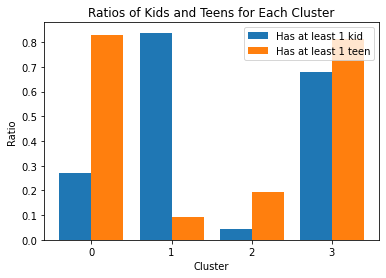

In [11]:
# plot side-by-side bar graphs for ratios of each cluster that have kids and teens

has_kids = [clust_0_kid, clust_1_kid, clust_2_kid, clust_3_kid]
has_teens = [clust_0_teen, clust_1_teen, clust_2_teen, clust_3_teen]
  
X_axis = np.arange(4)
  
plt.bar(X_axis - 0.2, has_kids, 0.4, label = 'Has at least 1 kid')
plt.bar(X_axis + 0.2, has_teens, 0.4, label = 'Has at least 1 teen')
  
plt.xticks(X_axis)
plt.xlabel("Cluster")
plt.ylabel("Ratio")
plt.title("Ratios of Kids and Teens for Each Cluster")
plt.legend()
plt.show()

- Cluster 0 generally has teens and few have kids.
- Cluster 1 generally has kids and few have teens.
- Cluster 2 generally doesn't have kids or teens.
- Cluster 3 generally has teens, and some have kids.

## Spending Habits

In [12]:
# get mean spending ratios of each cluster by product

clust_0_wine = clust_0['MntWines'].mean() / clust_0['Total_Spent'].mean()
clust_0_fruit = clust_0['MntFruits'].mean() / clust_0['Total_Spent'].mean()
clust_0_meat = clust_0['MntMeatProducts'].mean() / clust_0['Total_Spent'].mean()
clust_0_fish = clust_0['MntFishProducts'].mean() / clust_0['Total_Spent'].mean()
clust_0_sweet = clust_0['MntSweetProducts'].mean() / clust_0['Total_Spent'].mean()
clust_0_gold = clust_0['MntGoldProds'].mean() / clust_0['Total_Spent'].mean()

clust_1_wine = clust_1['MntWines'].mean() / clust_1['Total_Spent'].mean()
clust_1_fruit = clust_1['MntFruits'].mean() / clust_1['Total_Spent'].mean()
clust_1_meat = clust_1['MntMeatProducts'].mean() / clust_1['Total_Spent'].mean()
clust_1_fish = clust_1['MntFishProducts'].mean() / clust_1['Total_Spent'].mean()
clust_1_sweet = clust_1['MntSweetProducts'].mean() / clust_1['Total_Spent'].mean()
clust_1_gold = clust_1['MntGoldProds'].mean() / clust_1['Total_Spent'].mean()

clust_2_wine = clust_2['MntWines'].mean() / clust_2['Total_Spent'].mean()
clust_2_fruit = clust_2['MntFruits'].mean() / clust_2['Total_Spent'].mean()
clust_2_meat = clust_2['MntMeatProducts'].mean() / clust_2['Total_Spent'].mean()
clust_2_fish = clust_2['MntFishProducts'].mean() / clust_2['Total_Spent'].mean()
clust_2_sweet = clust_2['MntSweetProducts'].mean() / clust_2['Total_Spent'].mean()
clust_2_gold = clust_2['MntGoldProds'].mean() / clust_2['Total_Spent'].mean()

clust_3_wine = clust_3['MntWines'].mean() / clust_3['Total_Spent'].mean()
clust_3_fruit = clust_3['MntFruits'].mean() / clust_3['Total_Spent'].mean()
clust_3_meat = clust_3['MntMeatProducts'].mean() / clust_3['Total_Spent'].mean()
clust_3_fish = clust_3['MntFishProducts'].mean() / clust_3['Total_Spent'].mean()
clust_3_sweet = clust_3['MntSweetProducts'].mean() / clust_3['Total_Spent'].mean()
clust_3_gold = clust_3['MntGoldProds'].mean() / clust_3['Total_Spent'].mean()

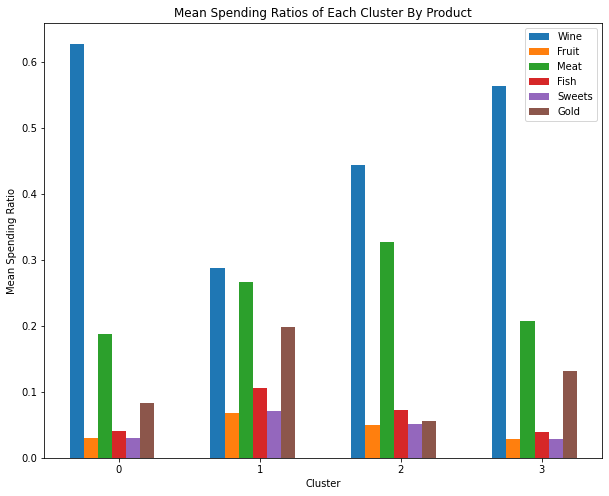

In [13]:
# plot mean spending ratios of each cluster by product

wine = [clust_0_wine, clust_1_wine, clust_2_wine, clust_3_wine]
fruit = [clust_0_fruit, clust_1_fruit, clust_2_fruit, clust_3_fruit]
meat = [clust_0_meat, clust_1_meat, clust_2_meat, clust_3_meat]
fish = [clust_0_fish, clust_1_fish, clust_2_fish, clust_3_fish]
sweet = [clust_0_sweet, clust_1_sweet, clust_2_sweet, clust_3_sweet]
gold = [clust_0_gold, clust_1_gold, clust_2_gold, clust_3_gold]

ind = np.arange(4) 
width = 0.1

plt.figure(figsize=(10,8))
bar1 = plt.bar(ind-width*2, wine, width)
bar2 = plt.bar(ind-width, fruit, width)
bar3 = plt.bar(ind, meat, width)
bar4 = plt.bar(ind+width, fish, width)
bar5 = plt.bar(ind+width*2, sweet, width)
bar6 = plt.bar(ind+width*3, gold, width)

plt.xlabel("Cluster")
plt.ylabel('Mean Spending Ratio')
plt.title("Mean Spending Ratios of Each Cluster By Product")
  
plt.xticks(ind+width, range(4))
plt.legend( (bar1, bar2, bar3, bar4, bar5, bar6), ('Wine', 'Fruit', 'Meat', 'Fish', 'Sweets', 'Gold') )
plt.show()

- All clusters allocate most of their spending to wine, followed by meat.
- Clusters 0 and 3 allocate much more spending to wine than they do to meat.
- Cluster 1 spends more on gold than any other cluster.

## Response to Deals and Promotions

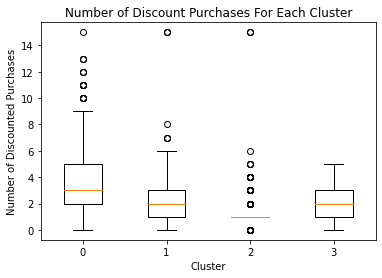

In [14]:
# draw a boxplot of each cluster's discounted purchases distribution
fig1, ax1 = plt.subplots()
ax1.set_title('Number of Discount Purchases For Each Cluster')
ax1.boxplot([clust_0['NumDealsPurchases'], clust_1['NumDealsPurchases'], clust_2['NumDealsPurchases'], 
             clust_3['NumDealsPurchases']], labels=range(4))
plt.xlabel("Cluster")
plt.ylabel("Number of Discounted Purchases")
plt.show()

- Clusters 0 and 1 are more likely to buy items on discount, and clusters 2 and 3 are less likely.

In [15]:
# get the ratio of each cluster that responded to each promotion

clust_0_promo_1 = len(clust_0[clust_0['AcceptedCmp1']==1]) / cluster_sizes[0]
clust_0_promo_2 = len(clust_0[clust_0['AcceptedCmp2']==1]) / cluster_sizes[0]
clust_0_promo_3 = len(clust_0[clust_0['AcceptedCmp3']==1]) / cluster_sizes[0]
clust_0_promo_4 = len(clust_0[clust_0['AcceptedCmp4']==1]) / cluster_sizes[0]
clust_0_promo_5 = len(clust_0[clust_0['AcceptedCmp5']==1]) / cluster_sizes[0]
clust_0_promo_6 = len(clust_0[clust_0['Response']==1]) / cluster_sizes[0]

clust_1_promo_1 = len(clust_1[clust_1['AcceptedCmp1']==1]) / cluster_sizes[1]
clust_1_promo_2 = len(clust_1[clust_1['AcceptedCmp2']==1]) / cluster_sizes[1]
clust_1_promo_3 = len(clust_1[clust_1['AcceptedCmp3']==1]) / cluster_sizes[1]
clust_1_promo_4 = len(clust_1[clust_1['AcceptedCmp4']==1]) / cluster_sizes[1]
clust_1_promo_5 = len(clust_1[clust_1['AcceptedCmp5']==1]) / cluster_sizes[1]
clust_1_promo_6 = len(clust_1[clust_1['Response']==1]) / cluster_sizes[1]

clust_2_promo_1 = len(clust_2[clust_2['AcceptedCmp1']==1]) / cluster_sizes[2]
clust_2_promo_2 = len(clust_2[clust_2['AcceptedCmp2']==1]) / cluster_sizes[2]
clust_2_promo_3 = len(clust_2[clust_2['AcceptedCmp3']==1]) / cluster_sizes[2]
clust_2_promo_4 = len(clust_2[clust_2['AcceptedCmp4']==1]) / cluster_sizes[2]
clust_2_promo_5 = len(clust_2[clust_2['AcceptedCmp5']==1]) / cluster_sizes[2]
clust_2_promo_6 = len(clust_2[clust_2['Response']==1]) / cluster_sizes[2]

clust_3_promo_1 = len(clust_3[clust_3['AcceptedCmp1']==1]) / cluster_sizes[3]
clust_3_promo_2 = len(clust_3[clust_3['AcceptedCmp2']==1]) / cluster_sizes[3]
clust_3_promo_3 = len(clust_3[clust_3['AcceptedCmp3']==1]) / cluster_sizes[3]
clust_3_promo_4 = len(clust_3[clust_3['AcceptedCmp4']==1]) / cluster_sizes[3]
clust_3_promo_5 = len(clust_3[clust_3['AcceptedCmp5']==1]) / cluster_sizes[3]
clust_3_promo_6 = len(clust_3[clust_3['Response']==1]) / cluster_sizes[3]

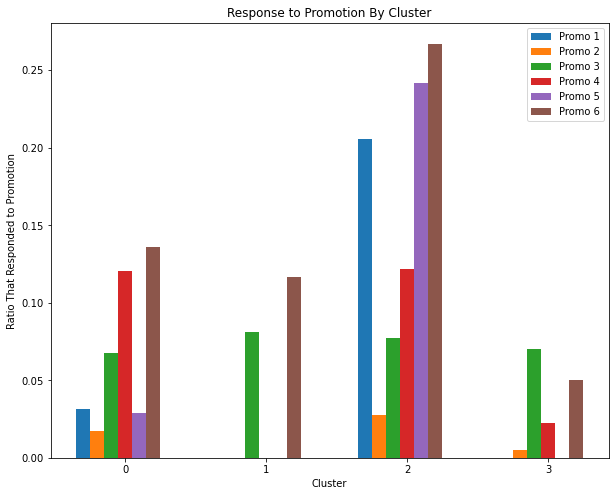

In [16]:
# plot ratio of each cluster that responded to each promotion

promo_1 = [clust_0_promo_1, clust_1_promo_1, clust_2_promo_1, clust_3_promo_1]
promo_2 = [clust_0_promo_2, clust_1_promo_2, clust_2_promo_2, clust_3_promo_2]
promo_3 = [clust_0_promo_3, clust_1_promo_3, clust_2_promo_3, clust_3_promo_3]
promo_4 = [clust_0_promo_4, clust_1_promo_4, clust_2_promo_4, clust_3_promo_4]
promo_5 = [clust_0_promo_5, clust_1_promo_5, clust_2_promo_5, clust_3_promo_5]
promo_6 = [clust_0_promo_6, clust_1_promo_6, clust_2_promo_6, clust_3_promo_6]

ind = np.arange(4) 
width = 0.1

plt.figure(figsize=(10,8))
bar1 = plt.bar(ind-width*2, promo_1, width)
bar2 = plt.bar(ind-width, promo_2, width)
bar3 = plt.bar(ind, promo_3, width)
bar4 = plt.bar(ind+width, promo_4, width)
bar5 = plt.bar(ind+width*2, promo_5, width)
bar6 = plt.bar(ind+width*3, promo_6, width)

plt.xlabel("Cluster")
plt.ylabel('Ratio That Responded to Promotion')
plt.title("Response to Promotion By Cluster")
  
plt.xticks(ind+width, range(4))
plt.legend( (bar1, bar2, bar3, bar4, bar5, bar6), ('Promo 1', 'Promo 2', 'Promo 3', 'Promo 4', 'Promo 5', 'Promo 6') )
plt.show()

- Cluster 2 responded the most to promotions, while Cluster 3 responded the least.
- Promo 6 was reasonably effective across all clusters.
- Promos 1 and 5 were effective for Cluster 2, but not for other clusters.
- Promo 4 was effective for Cluster 0, but not for other clusters.
- Promo 2 was not effective for any cluster.

## Shopping Methods

In [55]:
# get the average ratio that each shopping method that was used by each cluster

clust_0_web = clust_0['NumWebPurchases'].mean() / clust_0['Total_Purchases'].mean()
clust_0_catalog = clust_0['NumCatalogPurchases'].mean() / clust_0['Total_Purchases'].mean()
clust_0_store = clust_0['NumStorePurchases'].mean() / clust_0['Total_Purchases'].mean()

clust_1_web = clust_1['NumWebPurchases'].mean() / clust_1['Total_Purchases'].mean()
clust_1_catalog = clust_1['NumCatalogPurchases'].mean() / clust_1['Total_Purchases'].mean()
clust_1_store = clust_1['NumStorePurchases'].mean() / clust_1['Total_Purchases'].mean()

clust_2_web = clust_2['NumWebPurchases'].mean() / clust_2['Total_Purchases'].mean()
clust_2_catalog = clust_2['NumCatalogPurchases'].mean() / clust_2['Total_Purchases'].mean()
clust_2_store = clust_2['NumStorePurchases'].mean() / clust_2['Total_Purchases'].mean()

clust_3_web = clust_3['NumWebPurchases'].mean() / clust_3['Total_Purchases'].mean()
clust_3_catalog = clust_3['NumCatalogPurchases'].mean() / clust_3['Total_Purchases'].mean()
clust_3_store = clust_3['NumStorePurchases'].mean() / clust_3['Total_Purchases'].mean()

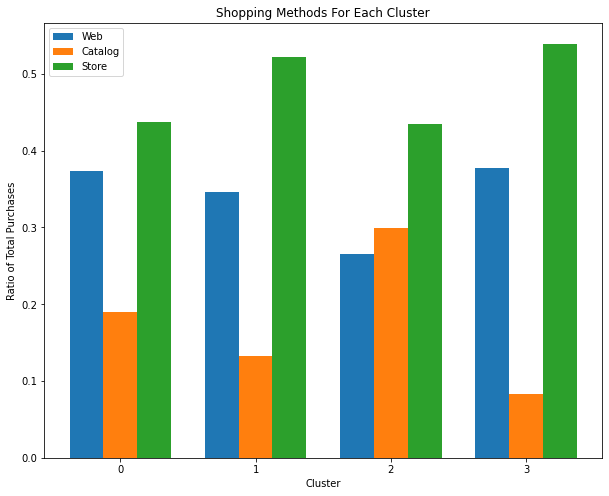

In [56]:
# plot the average ratio that each shopping method that was used by each cluster

web = [clust_0_web, clust_1_web, clust_2_web, clust_3_web]
catalog = [clust_0_catalog, clust_1_catalog, clust_2_catalog, clust_3_catalog]
store = [clust_0_store, clust_1_store, clust_2_store, clust_3_store]

ind = np.arange(4) 
width = 0.25

plt.figure(figsize=(10,8))
bar1 = plt.bar(ind, web, width)
bar2 = plt.bar(ind+width, catalog, width)
bar3 = plt.bar(ind+width*2, store, width)

plt.xlabel("Cluster")
plt.ylabel('Ratio of Total Purchases')
plt.title("Shopping Methods For Each Cluster")
  
plt.xticks(ind+width, range(4))
plt.legend( (bar1, bar2, bar3), ('Web', 'Catalog', 'Store') )
plt.show()

- All clusters made the majority of purchases in store.
- Cluster 2 made more catalog purchases and fewer web purchases than other clusters.